## Genetic Algorithm
### Estimate expression of a function using a number of given points

In [1]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sys import stdout
import warnings
warnings.filterwarnings('ignore')

### Tree representation of chromosomes

In this case, each chromosome is a function that is represented by a expression tree. The expression tree can include vertices with zero to two children. Tree leaves can be x or a constant number. Each non-leaf node is also a unary or binary operator.

### `class ExpressionNode`

It is an abstract class that contains information about a node in an expression tree.

In [2]:
class ExpressionNode:
    
    def __init__(self, value, is_operator, parent):
        self.value = value
        self.is_operator = is_operator
        self.parent = parent

    def evaluate(self, x):
        raise NotImplementedError()
    
    def inorder_array(self):
        raise NotImplementedError()
    
    def inorder(self):
        raise NotImplementedError()
        
    def clone(self, parent=None):
        raise NotImplementedError()
    
    def random_node(self):
        return np.random.choice(self.inorder_array())
    
    def replace_child(self, current, new):
        raise NotImplementedError()
    
    def __repr__(self):
        return self.inorder()

### `class ExpressionBinaryNode`

The class, which inherits from the ExpressionNode class, contains a binary node in the tree, which can have two operands left and right.
The binary operators used include addition, subtraction, multiplication, and division.

In [4]:
binary_operators = {
    '*': np.multiply,
    '/': np.divide,
    '+': np.add,
    '-': np.subtract}

class ExpressionBinaryNode(ExpressionNode):

    def __init__(self, value, parent:ExpressionNode=None, left:ExpressionNode=None, right:ExpressionNode=None):
        super().__init__(value, value in binary_operators, parent)
        self.right = right
        self.left = left

    def evaluate(self, x):
        if self.is_operator:
            evaluation = np.nan_to_num(binary_operators[self.value](self.left.evaluate(x), self.right.evaluate(x)), nan=float('inf'))
            return evaluation
        if self.value == 'x':
            return x
        return self.value
    
    def inorder_array(self):
        if self.is_operator:
            return self.left.inorder_array() + [self] + self.right.inorder_array()
        return [self]

    def inorder(self):
        if self.is_operator:
            return f'({self.left.inorder()} {self.value} {self.right.inorder()})'
        return str(self.value)
    
    def clone(self, parent:ExpressionNode=None):
        node = ExpressionBinaryNode(self.value, parent=parent)
        if self.is_operator:
            node.left = self.left.clone(parent=node)
            node.right = self.right.clone(parent=node)
        return node
    
    def replace_child(self, current:ExpressionNode, new:ExpressionNode):
        if current is self.left:
            self.left = new
        else:
            self.right = new
        new.parent = self

### `class ExpressionUnaryNode`

The class, which inherits from the ExpressionNode class, contains a unary node in the tree, which can have one operand.

The binary operators used include sin, cos, ln, exp and $-$(negate).

In [5]:
unary_operators = {'sin': np.sin, 'cos': np.cos, 'log': np.log, 'exp': np.exp, '- ': lambda x: -x}

class ExpressionUnaryNode(ExpressionNode):

    def __init__(self, value, parent:ExpressionNode=None, child:ExpressionNode=None):
        super().__init__(value, value in unary_operators, parent)
        self.child = child
            
    def evaluate(self, x):
        if self.is_operator:
            evaluation = np.nan_to_num(unary_operators[self.value](self.child.evaluate(x)), nan=float('inf'))
            return evaluation
        elif self.value == 'x':
            return x
        return self.value
    
    def inorder_array(self):
        if self.is_operator:
            return [self] + self.child.inorder_array()
        return [self]

    def inorder(self):
        inorder = self.pure_inorder()
        if isinstance(self.parent, ExpressionUnaryNode):
            return f'({inorder})'
        return inorder
    
    def pure_inorder(self):
        if self.is_operator:
            return f'{self.value}{self.child.inorder()}'
        return str(self.value)
    
    def clone(self, parent:ExpressionNode=None):
        node = ExpressionUnaryNode(self.value, parent=parent)
        if node.is_operator:
            node.child = self.child.clone(parent=node)
        return node
    
    def replace_child(self, current:ExpressionNode, new:ExpressionNode):
        self.child = new
        new.parent = self

### `class Expression`

The class contains an expression tree and its fitness.

In [6]:
class Expression:

    def __init__(self, root:ExpressionNode, fitness:float, evaluation):
        self.root = root
        self.fitness = fitness
        self.evaluation = evaluation
    
    def evaluate(self, x):
        return self.root.evaluate(x)
    
    def clone(self):
        return Expression(self.root.clone(), self.fitness, self.evaluation)
    
    def add(self, value:float, fitness:float):
        root = ExpressionBinaryNode('+')
        root.left = self.root
        self.root.parent = root
        root.right = ExpressionUnaryNode(value, root)
        self.evaluation += value
        self.fitness = fitness
        self.root = root
    
    def __repr__(self):
        return f'{self.root}\nfitness: {self.fitness}'
    
    def __lt__(self, other):
        return self.fitness < other.fitness

### `class RandomExpressionTreeGenerator`

With a random algorithm, this class creates a expression tree with the given maximum height. You can also specify the probability that a node is a leaf, and the probability that a leaf is a variable or a fixed number.

In [11]:
class RandomExpressionTreeGenerator:
    
    def create_random_leaf(self, variable_prob, parent:ExpressionNode):
        if np.random.uniform() < variable_prob:
            return ExpressionUnaryNode('x', parent=parent)
        return ExpressionUnaryNode(np.ceil(np.random.uniform(low=0, high=50)), parent=parent)
    
    def create_random_expression(self, max_height, leaf_prob=0.1, variable_prob=0.7, parent:ExpressionNode=None):
        if max_height == 0 or np.random.uniform() < leaf_prob:
            return self.create_random_leaf(variable_prob, parent)
        
        operator = np.random.choice(list(binary_operators.keys()) + list(unary_operators.keys()))

        if operator in binary_operators:
            node = ExpressionBinaryNode(operator, parent=parent)
            node.left = self.create_random_expression(max_height - 1, leaf_prob, variable_prob, node)
            node.right = self.create_random_expression(max_height - 1, leaf_prob, variable_prob, node)
            return node
        
        node = ExpressionUnaryNode(operator, parent=parent)
        node.child = self.create_random_expression(max_height - 1, leaf_prob, variable_prob, node)
        return node

### `class RandomMutator`

With a random algorithm, this class creates a expression tree with the given maximum height. You can also specify the probability that a node is a leaf, and the probability that a leaf is a variable or a fixed number.

This class is responsible for performing mutation operations on each chromosome. At first, with a given probability, decides whether to make the mutation or not. Then, if so, one of the following three operations  is done randomly:

1. Reverse operator of a random node. inverse of the operators are as follows:
    - $+ : -$
    - $\times : \div$
    - $\sin : \cos$
2. Negating a random node.
3. Replacing a node and its subtree with a random tree

In [12]:
operator_inverses = {'+': '-', '-': '+', '*': '/', '/': '*', 'sin': 'cos', 'cos': 'sin'}

class RandomMutator:

    def __init__(self, probability):
        self.probability = probability
        self.mutations = [self.invert_operator, self.negate, self.replace_by_random_tree]
    
    def adjust(self, root:ExpressionNode):
        if np.random.uniform() > self.probability:
            return root
        
        node = root.random_node()
        np.random.shuffle(self.mutations)

        for mutate in self.mutations:
            root, done = mutate(root, node)
            if done:
                return root
    
    def invert_operator(self, root:ExpressionNode, node:ExpressionNode):
        if node.value in operator_inverses:
            node.value = operator_inverses[node.value]
            return root, True
        return root, False
    
    def negate(self, root:ExpressionNode, node:ExpressionNode):
        negate_node = ExpressionUnaryNode('- ', node.parent, node)
        parent = node.parent
        node.parent = negate_node
        if parent:
            parent.replace_child(node, negate_node)
            return root, True
        return negate_node, True
    
    def replace_by_random_tree(self, root:ExpressionNode, node:ExpressionNode):
        tree_generator = RandomExpressionTreeGenerator()
        variable_node = tree_generator.create_random_expression(2, parent=node.parent)
        if node.parent:
            node.parent.replace_child(node, variable_node)
            return root, True
        return variable_node, True


### `class GeneticAlgorithm`

This class contains core of the genetic algorithm.

#### Fitness function

$$\mathcal{fitness}=\frac{1}{MSE(y_{train}, y_{predict})}$$

#### parameters

1. Population
2. Maximum number of generations
3. Maximum expected fitness
4. Mutation probability

#### Algorithm stages

1. **Generating train data**: At this stage, using the `generate_train_data` function, the train data is generated uniformly by giving the values of `size`, `low` and `high`. Also, if the data distribution needs to be something else, the input values of the training data can be given to this function.

Then the algorithm steps are performed using the `fit` function.

2. **Generating first generation**: At this stage, random functions are generated to generate the first generation by given population. The maximum tree height for each function is determined by a $\beta$ distribution as follows: ($\lceil \space \rceil$ is ceil function)
$$h \sim \lceil 7\beta(\alpha=1, \space \beta=3) \rceil$$
The distribution of heights in this way will be as follows:
![](beta.png)

3. **Choose parents**: At this stage, each generation chromosome is assigned a probability relative to its fitness. Then, from the current generation, with the given probabilities, and the possibility of repetitive selection, parents are randomly selected with size of population. These functions are then identified as parent pairs.

4. **Crossover**: At this point, a random node of two parent chromosomes are selected and replaced. As a result, two new chromosomes are formed. Vertices of each tree are selected uniformly.

5. **Mutation**: Each of the chromosomes produced is given to RandomMutator so that a mutation may occur.

6. **Finish condition**: Steps 3 to 5 are repeated until the generation number exceeds the specified maximum, or the fitness of the best generation function exceeds the specified maximum.

7. **Final adjuctment**: shift best function by $mean(y_{train} - y_{predicted})$ if there's a bias.

In [13]:
class GeneticAlgorithm:

    def __init__(self, real_function, population, last_generation, best_fitness=1, mutation_prob=1e-3):
        self.real_function = real_function
        self.population = population
        self.train_data = None
        self.current_generation = None
        self.best_function = None
        self.generation = 1
        self.last_generation = last_generation
        self.best_fitness = best_fitness
        self.start_time = None
        self.mutator = RandomMutator(mutation_prob)

    def generate_train_data(self, size=None, low=None, high=None, x=None):
        if x is None:
            x = np.random.uniform(low, high, size)
        self.train_data = pd.DataFrame({'x': x, 'y': self.real_function(x)})
    
    def create_first_generation(self):
        tree_generator = RandomExpressionTreeGenerator()
        iteration = 0
        while iteration < self.population:
            max_height = np.ceil(7 * np.random.beta(1, 3))
            root = tree_generator.create_random_expression(max_height)
            evaluation = root.evaluate(self.train_data.x)
            root_fitness = self.fitness(evaluation)

            if root_fitness > 0:
                yield Expression(root, root_fitness, evaluation)
            else:
                continue
            iteration += 1
    
    def fitness(self, evaluation:float):
        return np.divide(1, ((evaluation - self.train_data.y)**2).mean(axis=0))
    
    def drop_garbages(self):
        self.current_generation = self.current_generation[np.vectorize(lambda x: x.fitness)(self.current_generation) != 0]

    def choose_parents(self):
        self.drop_garbages()
        probabilities = np.nan_to_num([expr.fitness for expr in self.current_generation])
        probabilities /= np.sum(probabilities)

        choosen = np.random.choice(self.current_generation, size=self.population, p=probabilities)
        return np.array(list(map(lambda expression: expression.clone(), choosen))).reshape(self.population // 2, 2)
        
    def crossover(self, father:Expression, mother:Expression):
        father_node = father.root.random_node()
        father_parent = father_node.parent
        mother_node = mother.root.random_node()
        mother_parent = mother_node.parent
        
        first_child = father.root
        second_child = mother.root

        if father_parent:
            father_parent.replace_child(father_node, mother_node)
        else:
            first_child = mother_node
        
        if mother_parent:
            mother_parent.replace_child(mother_node, father_node)
        else:
            second_child = father_node
        
        first_child = self.mutator.adjust(first_child)
        second_child = self.mutator.adjust(second_child)

        first_evaluation = first_child.evaluate(self.train_data.x)
        second_evaluation = second_child.evaluate(self.train_data.x)

        return [Expression(first_child, self.fitness(first_evaluation), first_evaluation),
                Expression(second_child, self.fitness(second_evaluation), second_evaluation)]
    
    def generate_next_generation(self):
        parents = self.choose_parents()
        next_generation = np.concatenate(tuple((self.crossover(father, mother) for (father, mother) in parents)))
        return next_generation
    
    def print_status(self):
        stdout.write(f"\rgeneration: {self.generation} - elapsed: {int(1000 * (time.time() - self.start_time)):7d}ms - fitness: {self.best_function.fitness:10e} - best: {self.best_function.root}")
        stdout.flush()
    
    def plot_result(self, x, xlim=None, ylim=None):
        plt.figure(figsize=(25, 15))
        plt.plot(x, self.real_function(x), color='skyblue', label='original', linewidth=12, zorder=1)
        plt.scatter('x', 'y', data=self.train_data, color='green', label='train data', s=50, zorder=2)
        plt.plot(x, self.best_function.evaluate(x), color='red', label='predicted', linewidth=3, zorder=3)
        plt.grid()
        if xlim:
            plt.xlim(xlim)
        if ylim:
            plt.ylim(ylim)
        plt.legend()
    
    def final_adjustment(self):
        differences_mean = (self.train_data.y - self.best_function.evaluation).mean(axis=0)
        new_fitness = self.fitness(self.best_function.evaluation + differences_mean)
        self.best_function.add(differences_mean, new_fitness)
    
    def fit(self):
        if self.train_data is None:
            raise Exception('Train data is not ready. Use generate_train_data method.')
        if self.generation > 1:
            raise Exception('You already fitted the function.')

        self.current_generation = np.array(list(self.create_first_generation()))
        self.best_function = max(self.current_generation)
        self.start_time = time.time()

        while self.generation < self.last_generation and self.best_function.fitness < self.best_fitness:
            self.print_status()
            self.current_generation = self.generate_next_generation()
            self.best_function = max(self.current_generation)
            self.generation += 1

        self.final_adjustment()
        self.print_status()
        return self.best_function

### Solve some examples

1. $f(x)=-3x^2 + 4x - 10$

In [21]:
genetic = GeneticAlgorithm(lambda x: -3 * x ** 2 + 4 * x - 10, population=2000, last_generation=30, best_fitness=1e-3)
genetic.generate_train_data(200, -10000, 10000)
result = genetic.fit()

generation: 8 - elapsed:   21010ms - fitness: 1.047865e+16 - best: ((((x * x) - ((x - ((x + x) + (x + x))) - x)) - ((x + x) * (x + x))) + -10.00000000005577)

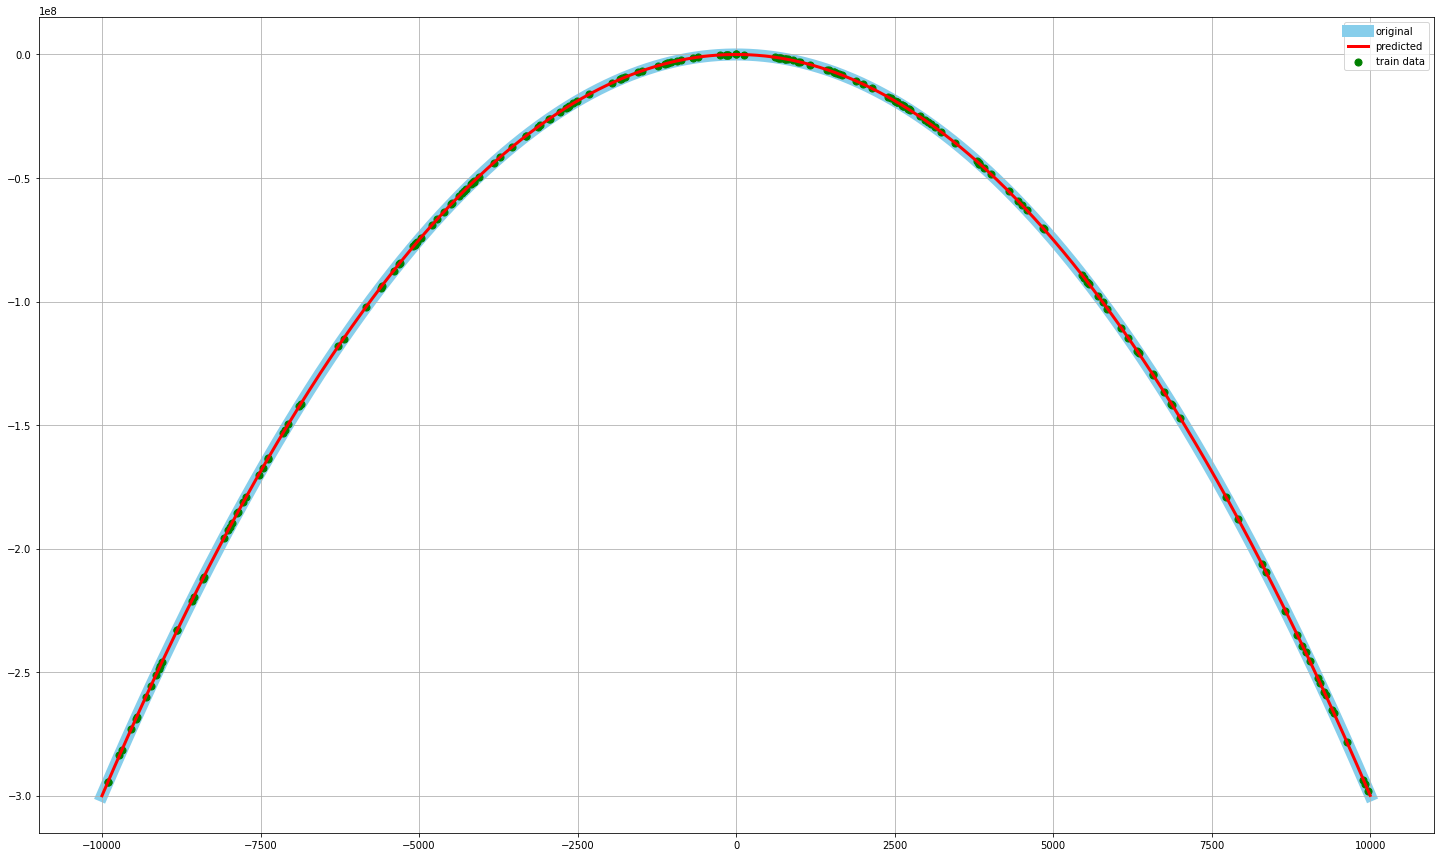

In [22]:
genetic.plot_result(np.array(range(-10000, 10000)))

2. $f(x)=-2x^3 - x^2 + 8x$

In [112]:
genetic = GeneticAlgorithm(lambda x: -2 * x ** 3 - x ** 2 + 8 * x, population=2000, last_generation=30)
genetic.generate_train_data(x = np.random.normal(scale=3, size=200))
result = genetic.fit()

generation: 17 - elapsed:   55173ms - fitness: 2.969400e+00 - best: ((- ((x + x) * (x * x)) - (((x * x) - (x + (((x - x) + (x + x)) * exp(cos((x + (x + x)) * ((x - x) * (- ((x + x) * (x * x)) - ((x * x) - x)))))))) - ((x / exp(cos((x + (x + x)) * ((x - x) * (- ((x + x) * (x * x)) - ((x * x) - x)))))) + x))) + -0.015225341927290931)

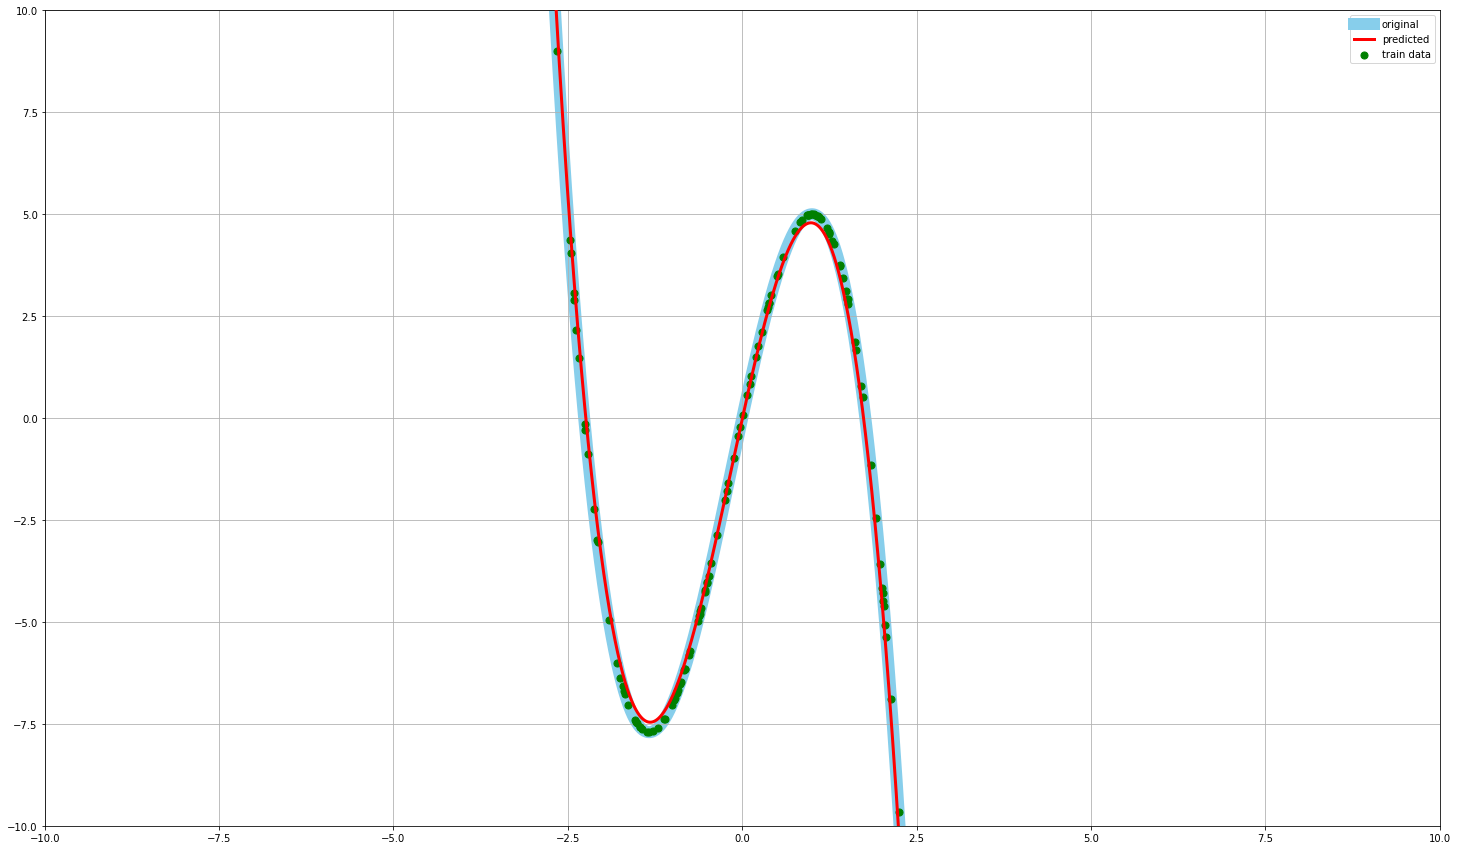

In [113]:
genetic.plot_result(np.arange(-10, 10, 0.001), xlim=(-10, 10), ylim=(-10, 10))

3. $f(x)=x^4 - x^3 - 4x^2 + 3x$

In [110]:
genetic = GeneticAlgorithm(lambda x: x ** 4 - x ** 3 - 4 * x ** 2 + 3 * x, population=2000, last_generation=30)
genetic.generate_train_data(x = np.random.normal(scale=6, size=400))
result = genetic.fit()

generation: 30 - elapsed:  148295ms - fitness: 6.896276e+23 - best: (((((x * - (x - - (x))) - - (- (x * - (x)) * - (x))) + (x + ((x - - (x)) + (- (x * - (x)) * (x * x))))) + ((x - - (x)) * - (x))) + 6.170858962706305e-14)

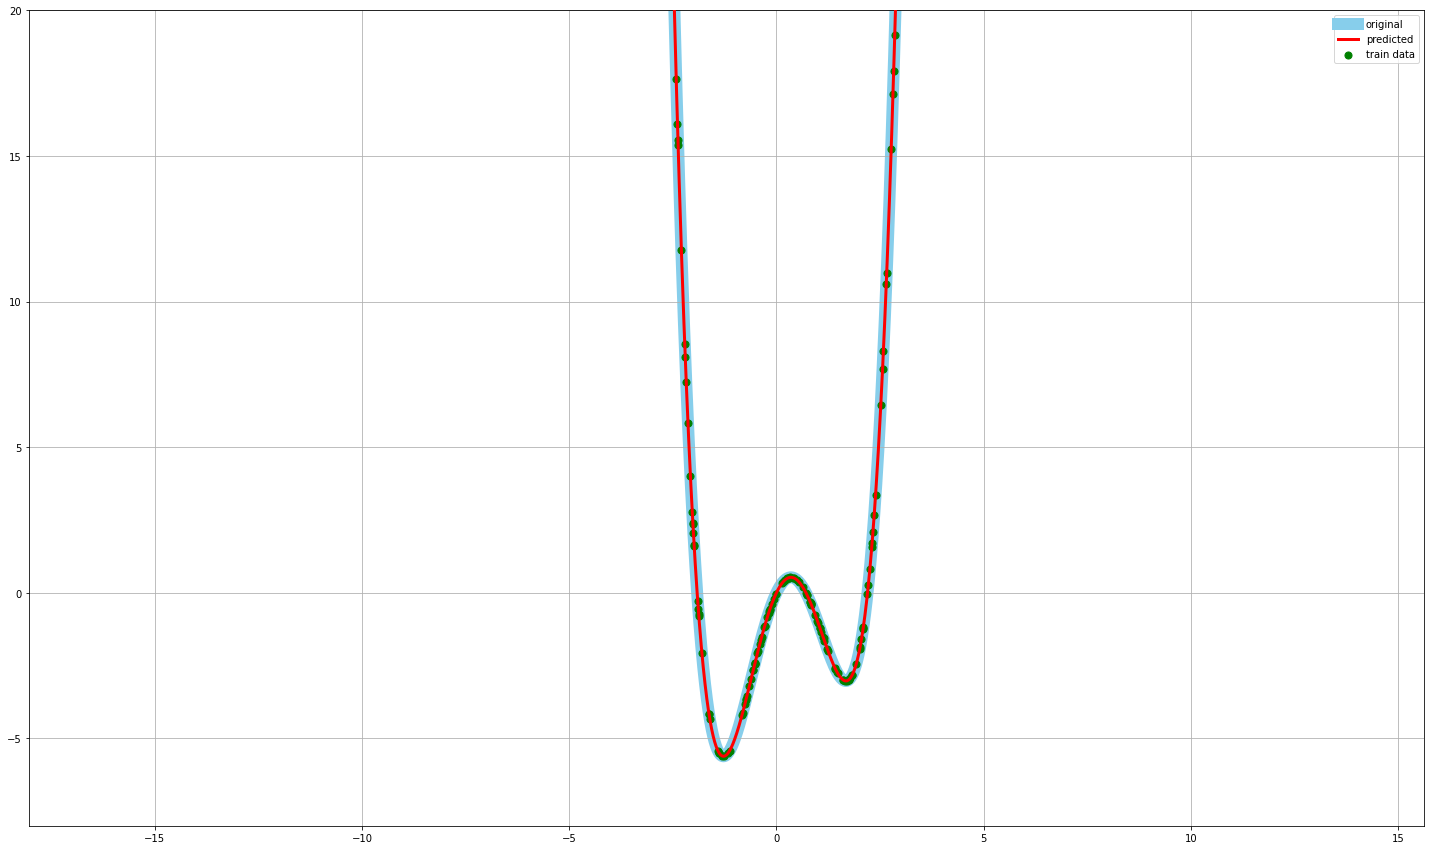

In [111]:
genetic.plot_result(np.arange(-10, 10, 0.001), ylim=(-8, 20))

4. $f(x) = x^2 \sin{x}$

In [27]:
genetic = GeneticAlgorithm(lambda x: x ** 2 * np.sin(x), population=2000, last_generation=30)
genetic.generate_train_data(200, -10, 10)
result = genetic.fit()

generation: 9 - elapsed:   13955ms - fitness: 2.774204e+29 - best: (((x * sin(x)) * x) + -1.914701036609401e-18)

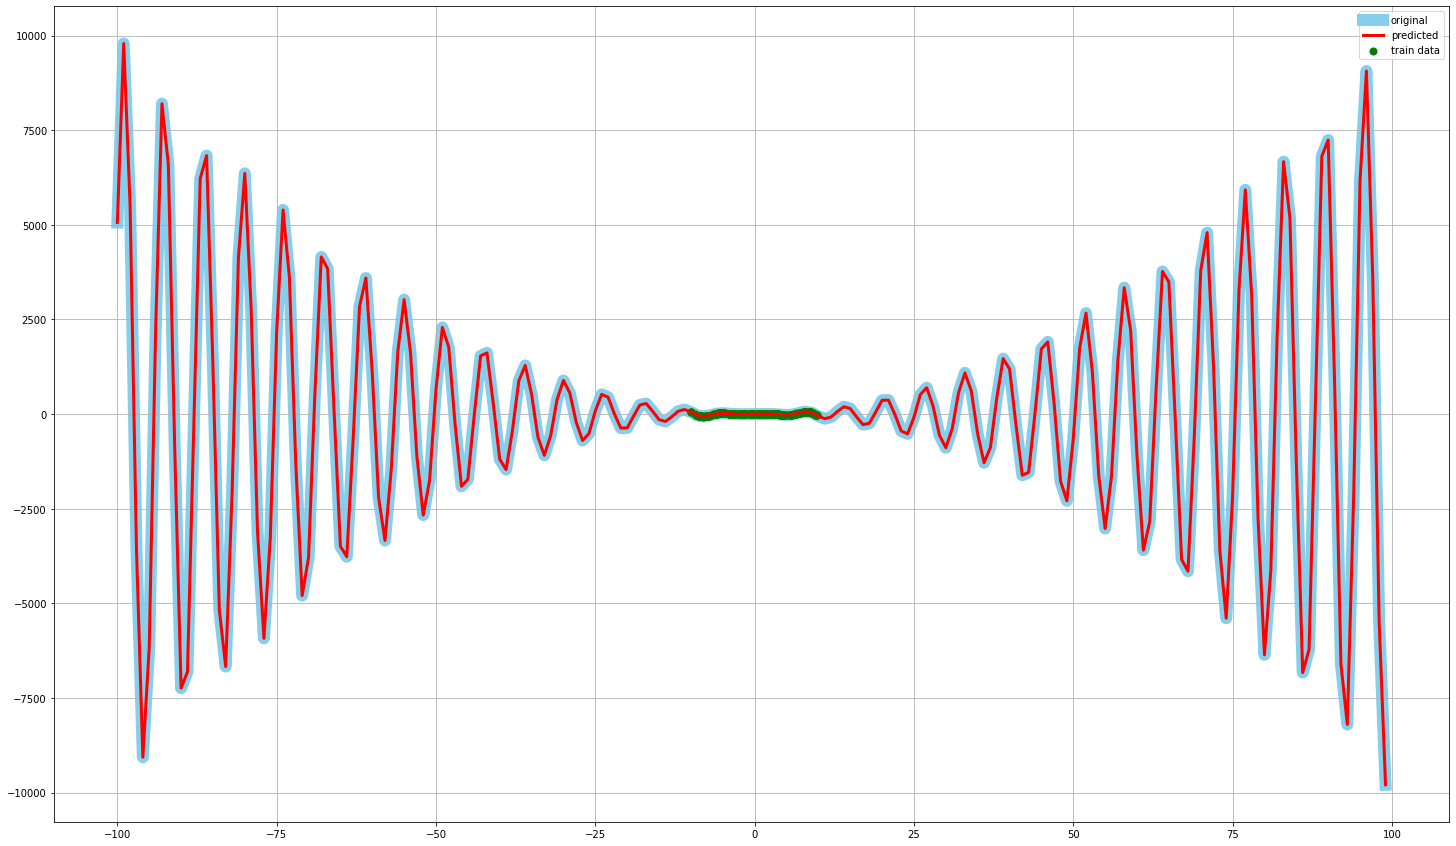

In [28]:
genetic.plot_result(np.array(range(-100, 100)))

5. $f(x) = \frac{1}{x}$

In [39]:
genetic = GeneticAlgorithm(lambda x: np.divide(1, x), population=2000, last_generation=30)
genetic.generate_train_data(x = np.random.normal(scale=5, size=200))
result = genetic.fit()

generation: 1 - elapsed:       0ms - fitness: 2.449138e+29 - best: ((x / (x * x)) + -1.50712775592865e-16)

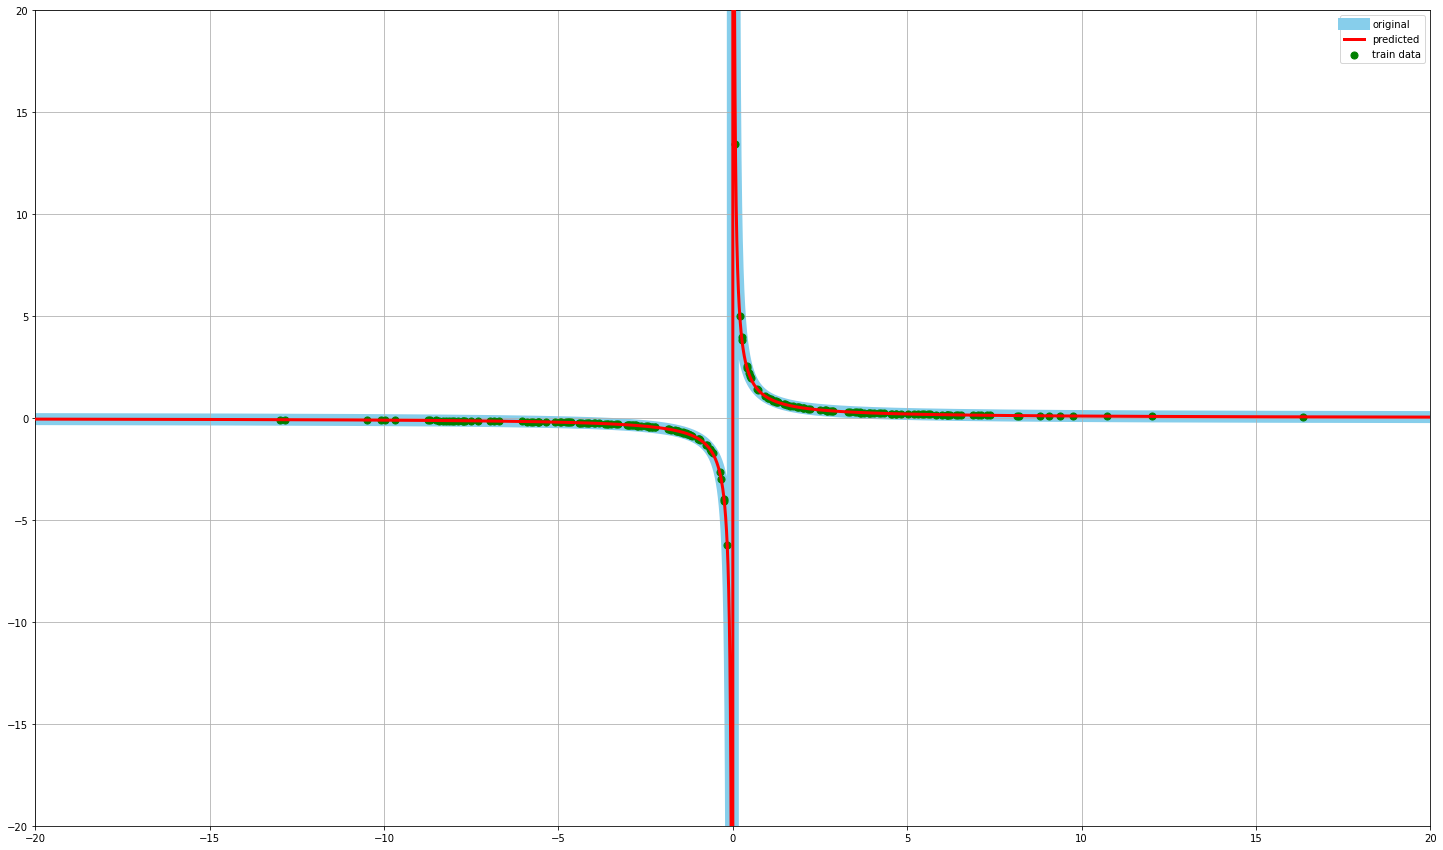

In [40]:
genetic.plot_result(np.arange(-20, 20, 0.0001), xlim=(-20, 20), ylim=(-20, 20))

6. $f(x) = \frac{2x^3 - 5x + 4}{x^2 - 1}$

In [126]:
genetic = GeneticAlgorithm(lambda x: np.divide(2 * x ** 3 - 5 * x + 4, x ** 2 - 1), population=2000, last_generation=30)
genetic.generate_train_data(x = np.random.normal(scale=6, size=400))
result = genetic.fit()

generation: 30 - elapsed:   44632ms - fitness: 6.117042e-01 - best: (((x + x) + ((x + (x + x)) / (((x + x) / (x + x)) + x))) + -3.036408097153609)

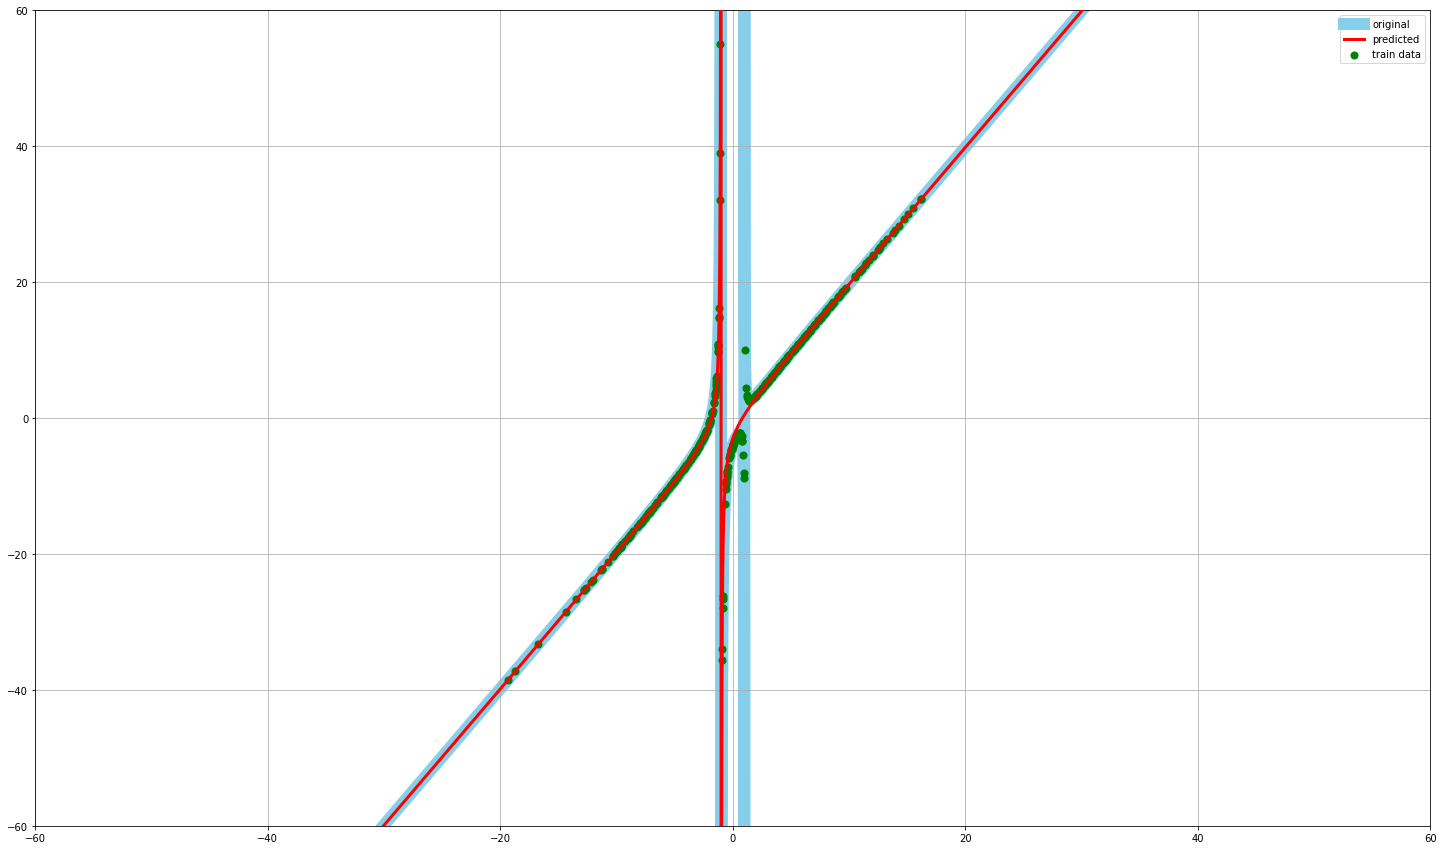

In [127]:
genetic.plot_result(np.arange(-60, 60, 0.0001), xlim=(-60, 60), ylim=(-60, 60))

7. $f(x) = \ln(x^4)$

In [49]:
genetic = GeneticAlgorithm(lambda x: np.log(x ** 4), population=2000, last_generation=30, best_fitness=1e2)
genetic.generate_train_data(x=np.concatenate((np.random.uniform(0, 200, 200), np.random.uniform(200, 1000, 200))))
result = genetic.fit()

generation: 5 - elapsed:    7727ms - fitness: 4.368855e+30 - best: (log(((x * x) * x) * x) + 1.27675647831893e-17)

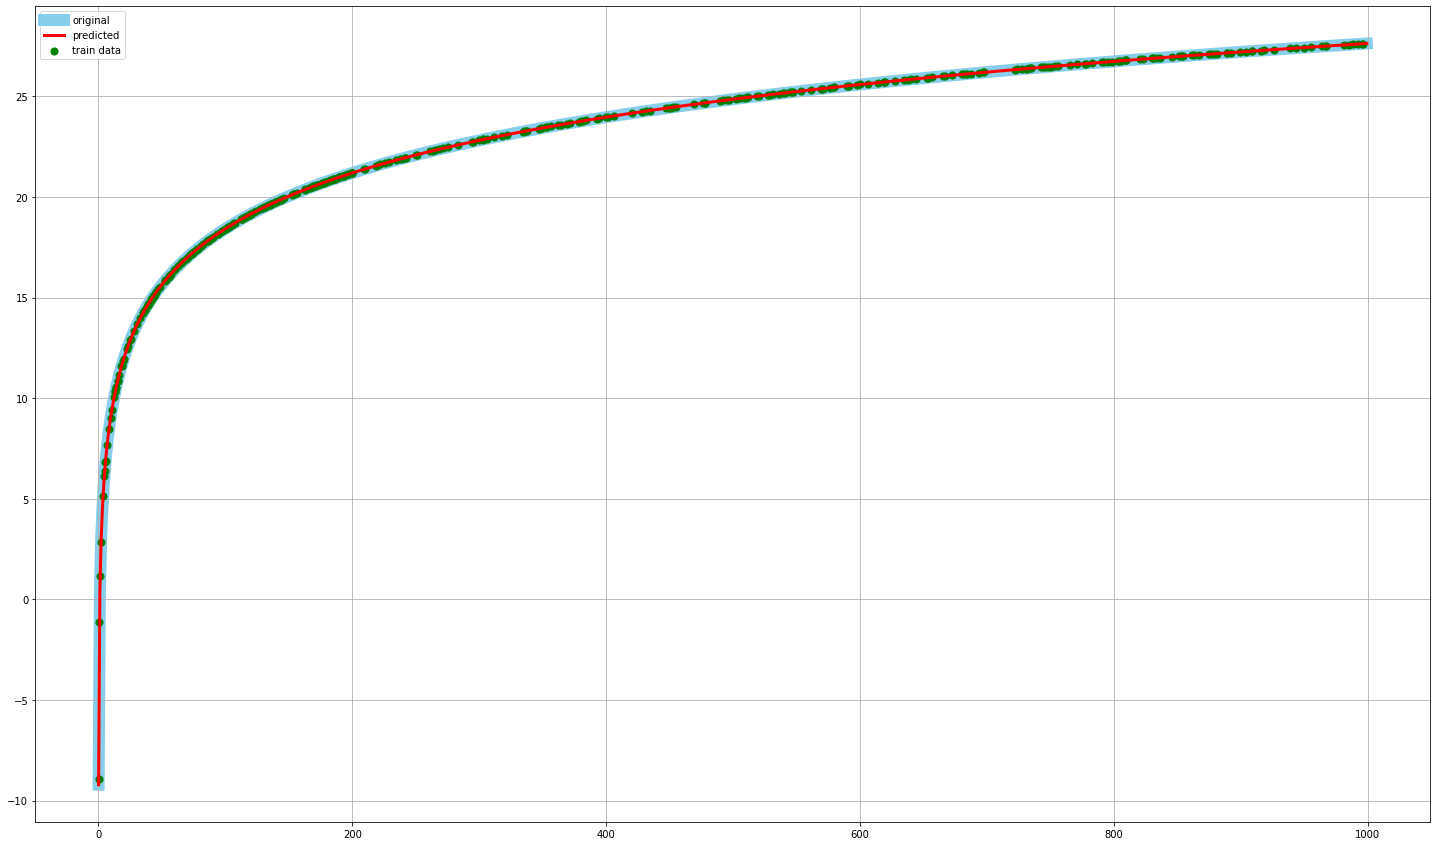

In [54]:
genetic.plot_result(np.arange(1e-1, 1000, 1))

8. $f(x) = \sin(x^3)$

In [35]:
genetic = GeneticAlgorithm(lambda x: np.sin(x ** 3), population=2000, last_generation=30, best_fitness=1e1)
genetic.generate_train_data(200, -10, 10)
result = genetic.fit()

generation: 15 - elapsed:   56260ms - fitness: 2.186786e+27 - best: (sin(x * (x * x)) + 1.8835952762807916e-15)

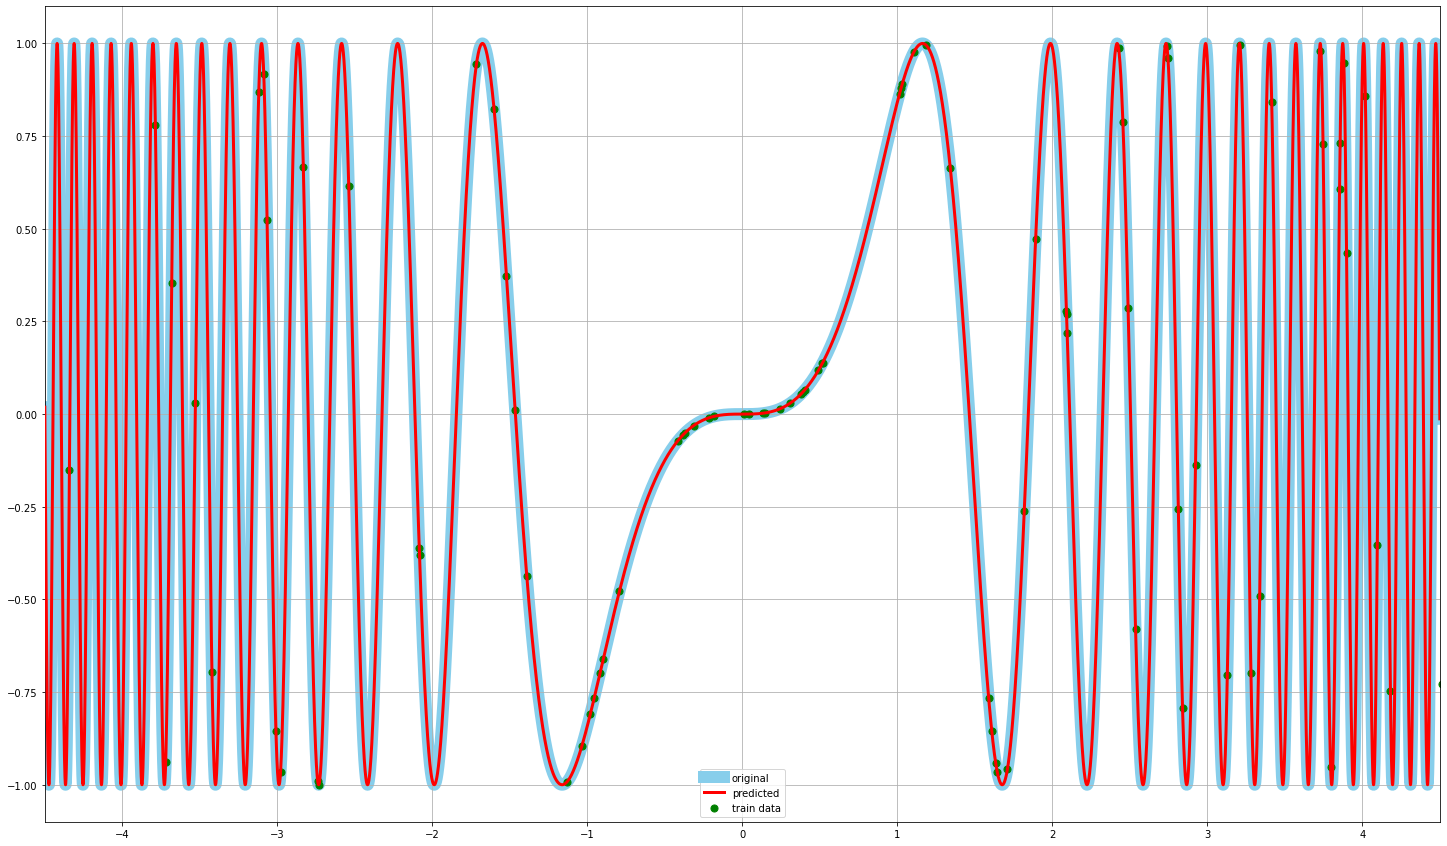

In [36]:
genetic.plot_result(np.arange(-4.5, 4.5, 0.0001), xlim=(-4.5, 4.5))

9. $f(x) = 8x^2 + 7$

In [27]:
genetic = GeneticAlgorithm(lambda x: 8 * x ** 2 + 7, population=2000, last_generation=30, best_fitness=1e-2)
genetic.generate_train_data(50, -5000, 5000)
result = genetic.fit()

generation: 7 - elapsed:    9395ms - fitness: 1.589264e+16 - best: ((((- (x * (x / x)) / 9.0) + x) * (9.0 * x)) + 6.999999998006952)

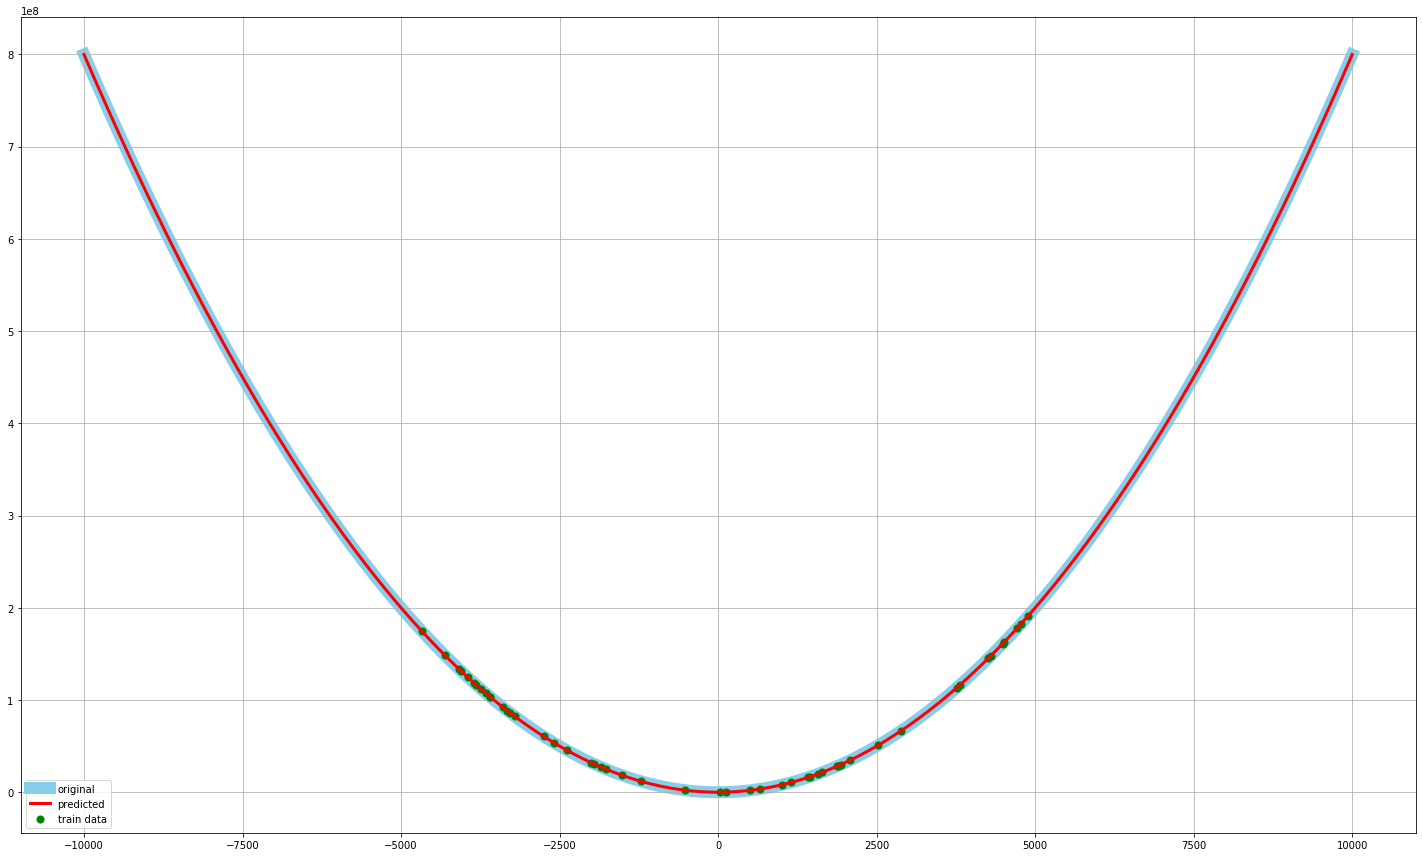

In [28]:
genetic.plot_result(np.arange(-10000, 10000, 1))

10. $f(x) = 20x + 52$

In [19]:
genetic = GeneticAlgorithm(lambda x: 20 * x + 52, population=2000, last_generation=30, best_fitness=1e-4)
genetic.generate_train_data(size=50, low=100, high=1000)
result = genetic.fit()

generation: 1 - elapsed:       0ms - fitness:        inf - best: ((2.0 * (x * 10.0)) + 52.0)

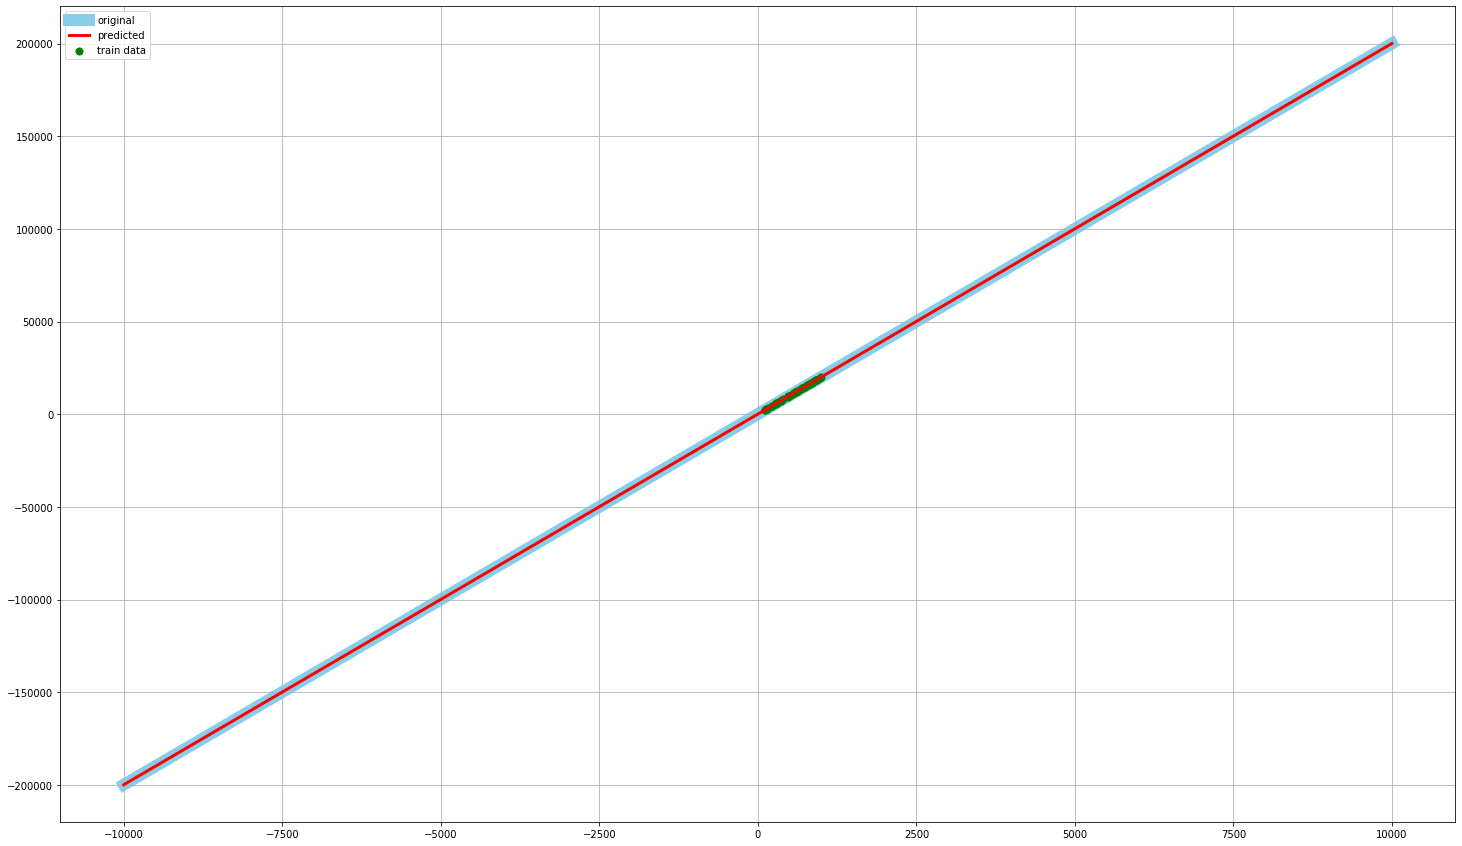

In [20]:
genetic.plot_result(np.arange(-10000, 10000, 1))